<a href="https://colab.research.google.com/github/DarkLord0206/A2C/blob/main/06-convnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Outline

* Today we will show how to train a ConvNet using PyTorch
* We will also illustrate how the ConvNet makes use of specific assumptions

# To perform well, we need to incorporate some prior knowledge about the problem

* Assumptions helps us when they are true
* They hurt us when they are not
* We want to make just the right amount of assumptions, not more than that

## In Deep Learning

* Many layers: compositionality
* Convolutions: locality + stationarity of images
* Pooling: Invariance of object class to translations

In [9]:
import matplotlib as mpl
import numpy as np
import torch
from IPython.display import clear_output
from matplotlib import pyplot as plt


def set_default(figsize=(10, 10), dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)


def plot_data(X, y, d=0, auto=False, zoom=1, title='Training data (x, y)'):
    X = X.cpu()
    y = y.cpu()
    s = plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.axis('square')
    plt.axis(np.array((-1.1, 1.1, -1.1, 1.1)) * zoom)
    if auto is True: plt.axis('equal')
    plt.axis('off')

    _m, _c = 0, '.35'
    plt.axvline(0, ymin=_m, color=_c, lw=1)
    plt.axhline(0, xmin=_m, color=_c, lw=1)
    plt.title(title)
    return s


def plot_model(X, y, model):
    model.cpu()
    mesh = torch.arange(-1.1, 1.1, 0.01)
    xx, yy = torch.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.stack((xx.reshape(-1), yy.reshape(-1)), dim=1)
        Z = model(data)
    Z = Z.argmax(dim=1).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plot_data(X, y)
    plt.title('Model decision boundaries')


def plot_embeddings(X, y, model, zoom=10):
    # Use forward hook to get internal embeddings of the second last layer
    layer_outputs = {}

    def get_layer_outputs(name):
        def hook(model, input, output):
            layer_outputs[name] = output

        return hook

    layer = model[-2]

    if layer.__class__ == torch.nn.modules.linear.Linear and layer.out_features == 2:
        layer.register_forward_hook(get_layer_outputs("low_dim_embeddings"))
        with torch.no_grad():
            model(X)  # pass data through model to populate layer_outputs
        plot_data(
            layer_outputs["low_dim_embeddings"],
            y,
            zoom=zoom,
            title="Low dim embeddings",
        )
        last_layer = model[-1]
        mesh = torch.arange(-1.1, 1.1, 0.01) * zoom
        xx, yy = torch.meshgrid(mesh, mesh, indexing="ij")
        with torch.no_grad():
            data = torch.stack((xx.reshape(-1), yy.reshape(-1)), dim=1)
            Z = last_layer(data)
        Z = Z.argmax(dim=1).reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3, levels=y.max().item())
    else:
        print(
            "Cannot plot: second-last layer is not a linear layer"
            f" with output in R^2 (it is {layer})"
        )


def acc(l, y):
    score, predicted = torch.max(l, 1)
    return (y == predicted).sum().float() / len(y)


def overwrite(string):
    print(string)
    clear_output(wait=True)


def plot_2d_energy_levels(X, y, energy, v=None, l=None):
    xx, yy, F, k, K = energy
    if not v: vmin = vmax = None
    else: vmin, vmax = v
    if not l: levels = None
    else: levels = torch.arange(l[0], l[1], l[2])
    plt.figure(figsize=(12, 10))
    plt.pcolormesh(xx, yy, F, vmin=vmin, vmax=vmax)
    plt.colorbar()
    cnt = plt.contour(xx, yy, F, colors='w', linewidths=1, levels=levels)
    plt.clabel(cnt, inline=True, fontsize=10, colors='w')
    s = plot_data(X, y)
    plt.legend(*s.legend_elements(), title='Classes', loc='lower right')
    plt.axvline(color='0.55', lw=1)
    plt.axhline(color='0.55', lw=1)
    plt.axis([-1.5, 1.5, -1.5, 1.5])
    ȳ = torch.zeros(K).int(); ȳ[k] = 1
    plt.title(f'Free energy F(x, y = {ȳ.tolist()})')


def plot_3d_energy_levels(X, y, energy, v=None, l=None, cbl=None):
    xx, yy, F, k, K = energy
    if not v: vmin = vmax = None
    else: vmin, vmax = v
    if not l: levels = None
    else: levels = torch.arange(l[0], l[1], l[2])
    fig = plt.figure(figsize=(9.5, 6), facecolor='k')
    ax = fig.add_subplot(projection='3d')
    cnt = ax.contour(xx, yy, F, levels=levels, vmin=vmin, vmax=vmax)
    ax.scatter(X[:,0], X[:,1], zs=0, c=y, cmap=plt.cm.Spectral)
    ax.xaxis.set_pane_color(color=(0,0,0))
    ax.yaxis.set_pane_color(color=(0,0,0))
    ax.zaxis.set_pane_color(color=(0,0,0))

    vmin, vmax = cnt.get_clim()
    ax.set_zlim3d(vmin, vmax)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    if not cbl: cbl = l
    else: cbl = torch.arange(cbl[0], cbl[1], cbl[2])
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cnt.cmap)
    sm.set_array([])
    fig.colorbar(sm, ticks=cbl)
    ȳ = torch.zeros(K).int(); ȳ[k] = 1
    plt.title(f'Free energy F(x, y = {ȳ.tolist()})')
    plt.tight_layout()
    return fig, ax

In [10]:
set_default()

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy

# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the Dataset (MNIST)


We can use some PyTorch DataLoader utilities for this. This will download, shuffle, normalize data and arrange it in batches.

In [13]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



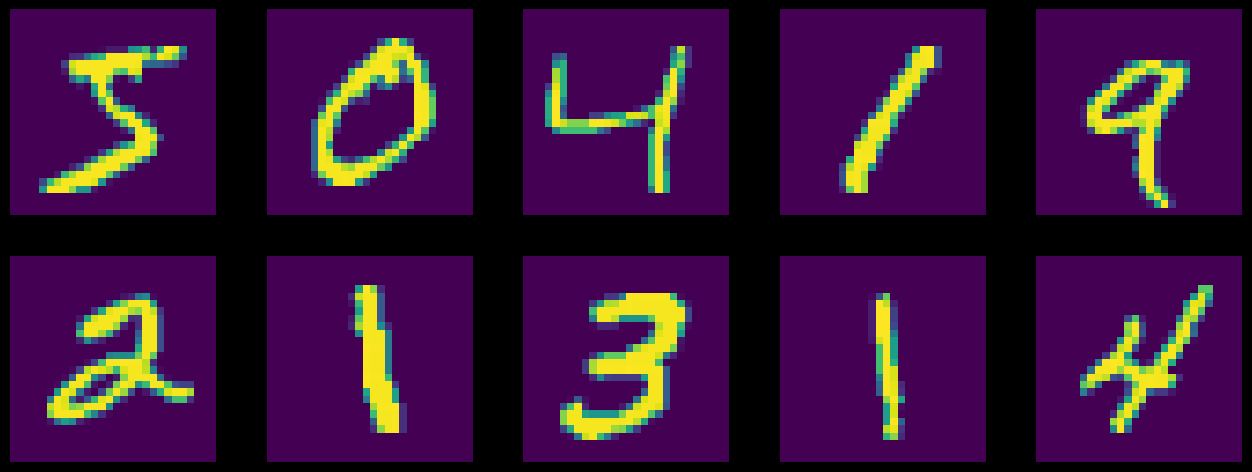

In [14]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

# Create the model classes

In [15]:
class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, output_size), 
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)
    
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

## Running on a GPU: device string

Switching between CPU and GPU in PyTorch is controlled via a device string, which will seemlessly determine whether GPU is available, falling back to CPU if not:

In [16]:
accuracy_list = []

def train(epoch, model, perm=torch.arange(0, 784).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

# Train a small fully-connected network

In [17]:
n_hidden = 8 # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn)
    test(model_fnn)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.322260
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.876216
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.578752
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.024857
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.876138
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.726367
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.714634
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.705093
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.382517
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.617578

Test set: Average loss: 0.4458, Accuracy: 8631/10000 (86%)



# Train a ConvNet with the same number of parameters

In [18]:
# Training settings 
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn)
    test(model_cnn)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.309923
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.975781
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.613453
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.463386
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.364519
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.294873
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.275336
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.381722
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.143069
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.244058

Test set: Average loss: 0.1576, Accuracy: 9518/10000 (95%)



# The ConvNet performs better with the same number of parameters, thanks to its use of prior knowledge about images

* Use of convolution: Locality and stationarity in images
* Pooling: builds in some translation invariance

# What happens if the assumptions are no longer true?


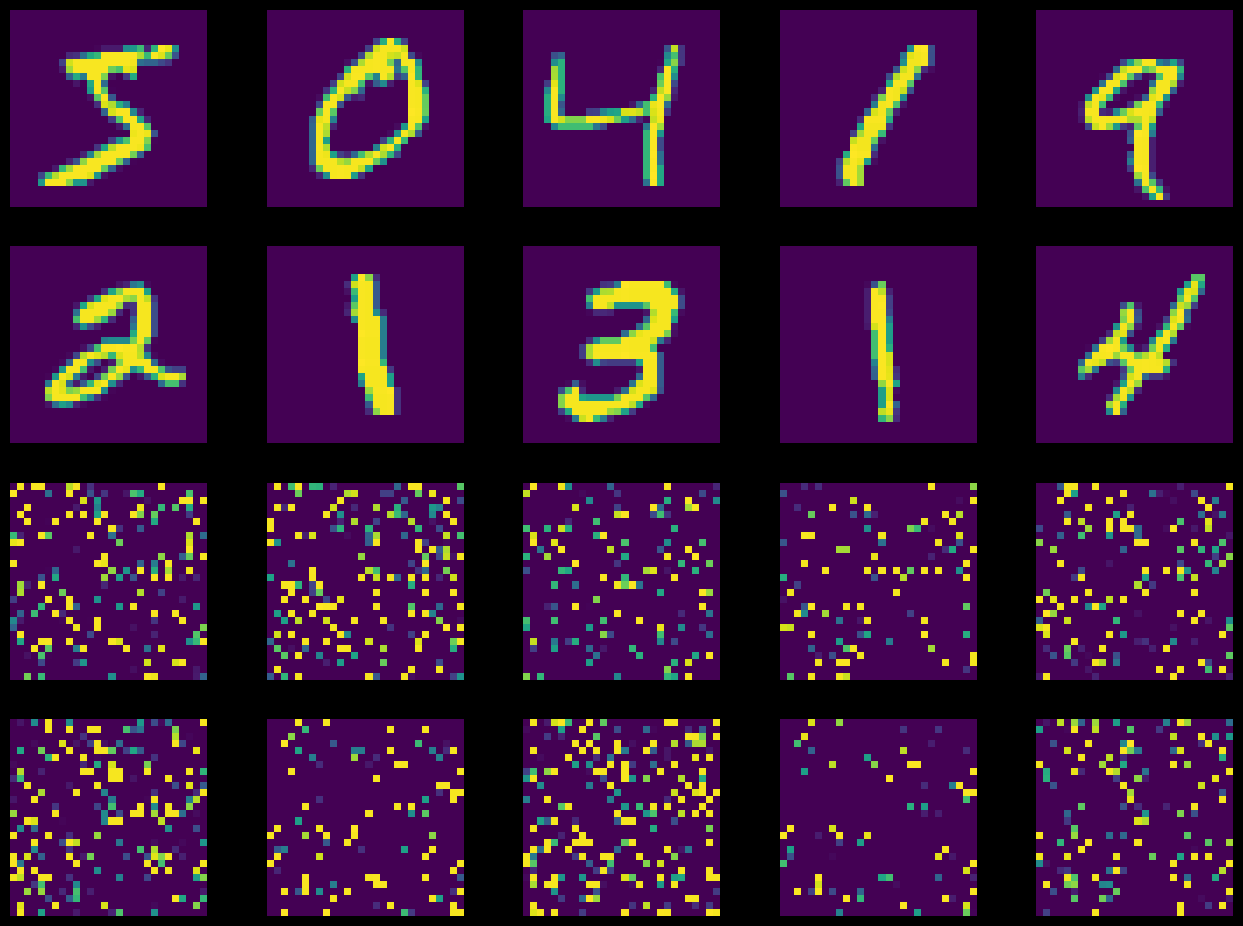

In [19]:
perm = torch.randperm(784)
plt.figure(figsize=(16, 12))
for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)
    # permute pixels
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')

# ConvNet with permuted pixels

In [20]:
# Training settings 
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn, perm)
    test(model_cnn, perm)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.342007
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.281891
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.194565
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.792248
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.273887
Train Epoch: 0 [32000/60000 (53%)]	Loss: 1.278549
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.753195
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.777848
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.732316
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.591034

Test set: Average loss: 0.5713, Accuracy: 8231/10000 (82%)



# Fully-Connected with Permuted Pixels

In [21]:
n_hidden = 8    # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn, perm)
    test(model_fnn, perm)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.372780
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.786637
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.103877
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.813806
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.646226
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.694374
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.419400
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.477072
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.434907
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.381939

Test set: Average loss: 0.4011, Accuracy: 8792/10000 (88%)



# The ConvNet's performance drops when we permute the pixels, but the Fully-Connected Network's performance stays the same

* ConvNet makes the assumption that pixels lie on a grid and are stationary/local
* It loses performance when this assumption is wrong
* The fully-connected network does not make this assumption
* It does less well when it is true, since it doesn't take advantage of this prior knowledge
* But it doesn't suffer when the assumption is wrong

In [ ]:
plt.bar(('NN image', 'CNN image',
         'CNN scrambled', 'NN scrambled'),
        accuracy_list, width=0.4)
plt.ylim((min(accuracy_list)-5, 96))
plt.ylabel('Accuracy [%]')
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
plt.title('Performance comparison');

### Checking Model Parameters

In [22]:
print(dir(model_cnn))

['T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_buffers', '_call_impl', '_forward_hooks', '_forward_pre_hooks', '_get_backward_hooks', '_get_name', '_is_full_backward_hook', '_load_from_state_dict', '_load_state_dict_post_hooks', '_load_state_dict_pre_hooks', '_maybe_warn_non_full_backward_hook', '_modules', '_named_members', '_non_persistent_buffers_set', '_parameters', '_register_load_state_dict_pre_hook', '_register_state_dict_hook', '_replicate_for_data_parallel', '_save_to_state_dict', '_slow_forward', '_state_dict_hooks', '_version', 'add_module', 'apply', 'bfloat16', 'buffers', '

In [23]:
print(dir(model_fnn))

['T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_buffers', '_call_impl', '_forward_hooks', '_forward_pre_hooks', '_get_backward_hooks', '_get_name', '_is_full_backward_hook', '_load_from_state_dict', '_load_state_dict_post_hooks', '_load_state_dict_pre_hooks', '_maybe_warn_non_full_backward_hook', '_modules', '_named_members', '_non_persistent_buffers_set', '_parameters', '_register_load_state_dict_pre_hook', '_register_state_dict_hook', '_replicate_for_data_parallel', '_save_to_state_dict', '_slow_forward', '_state_dict_hooks', '_version', 'add_module', 'apply', 'bfloat16', 'buffers', '